# Beyin MR Görüntüleri ile Transfer Learning Kullanarak Tümör Sınıflandırma

Bu projede, beyin MR görüntülerini kullanarak tümör sınıflandırma görevini ele alıyoruz. Amacımız, önceden eğitilmiş bir VGG16 modelini kullanarak, bu görüntüler üzerinde derin öğrenme uygulayarak beyin tümörlerini sınıflandırmak. Ayrıca, veri setini daha çeşitli ve sağlam hale getirmek için veri augmentasyonu kullanılacaktır.

## Adım 1: Veri Keşfi ve Analizi
Başlangıç olarak, kullanılacak veri setini inceledik. Veri setinin yapısı, boyutları ve içeriği hakkında bilgi edindik.

## Adım 2: Veri Temizliği
Eğer veri setinde eksik veya hatalı veriler varsa, bu aşamada temizledik. Temiz veri, daha güçlü bir model eğitimine olanak sağlar.

## Adım 3: Data Augmentasyonu
Veri setini daha da zenginleştirmek için veri augmentasyonu kullandık. Görüntüler üzerinde döndürme, yansıtma, kesme, vb. işlemleri uygulayarak veri çeşitliliğini artırdık.

## Adım 4: Modelin Kurulması ve Eğitilmesi
Transfer learning kullanarak VGG16 modelini kurup eğittik. Ağırlıkları dondurma veya dondurmama seçeneklerini değerlendirdik ve modeli eğitirken kullanılacak parametreleri ayarladık.

## Adım 5: Sonuçlar ve Değerlendirme
Modelimizin performansını değerlendirdik. Sonuçlar, sınıflandırma doğruluğu, hassasiyet, özgüllük gibi metriklerle sunuldu.


## Teknolojiler ve Araçlar

- Python
- TensorFlow
- Keras
- cv2

In [34]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import os
os.chdir('/content/drive/My Drive/sihArohi/HTM/Arohi28oct/archive (14)')

Mounted at /content/drive


In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [36]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

In [37]:
from pathlib import Path
import cv2
import numpy as np
from tqdm import tqdm

#labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

X_train = []
y_train = []
X_test = []
y_test = []

image_size = 180

# Define the base directory
base_dir = Path('/content/drive/My Drive/sihArohi/HTM/Arohi28oct/archive (14)/Brain-Tumor-Classification-DataSet-master')

# Load training data
for label in labels:
    training_dir = base_dir / 'Training' / label
    for img_path in tqdm(training_dir.glob('*.*')):
        img = cv2.imread(str(img_path))
        img = cv2.resize(img, (image_size, image_size))
        # Apply data augmentation here if needed
        X_train.append(img)
        y_train.append(label)

# Load testing data
for label in labels:
    testing_dir = base_dir / 'Testing' / label
    for img_path in tqdm(testing_dir.glob('*.*')):
        img = cv2.imread(str(img_path))
        img = cv2.resize(img, (image_size, image_size))
        X_test.append(img)
        y_test.append(label)

# Convert data to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)




826it [00:05, 143.19it/s]
395it [00:02, 189.38it/s]
822it [00:04, 178.27it/s]
827it [00:05, 143.29it/s]
100it [00:00, 124.65it/s]
105it [00:00, 232.67it/s]
115it [00:00, 158.94it/s]
74it [00:00, 84.18it/s]


# **Veri Analizi**

In [38]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

In [39]:
size_images = 180
batch_size = 64

In [40]:

# Specify the training data directory using Path
train_data_dir = base_dir / 'Training'

# Use train_data_dir in your flow_from_directory method
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(size_images, size_images),
    batch_size=batch_size,
    seed=32,
    shuffle=True,
    class_mode='categorical'
)


Found 2870 images belonging to 4 classes.


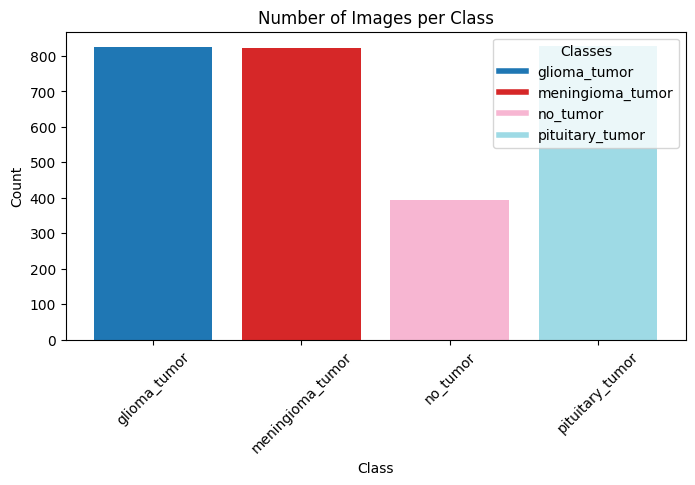

In [41]:
# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(train_generator)):
    batch_data, batch_labels = train_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

# Add a legend for class colors
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

In [42]:
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

In [43]:


# Specify the testing data directory using Path
test_data_dir = base_dir / 'Testing'

# Create a generator for testing data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(size_images, size_images),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 394 images belonging to 4 classes.


In [44]:
def Show_Images(target_gen):
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = list(target_gen.class_indices.keys())

    # Display images with labels
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),36))):
        plt.subplot(6, 6, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()

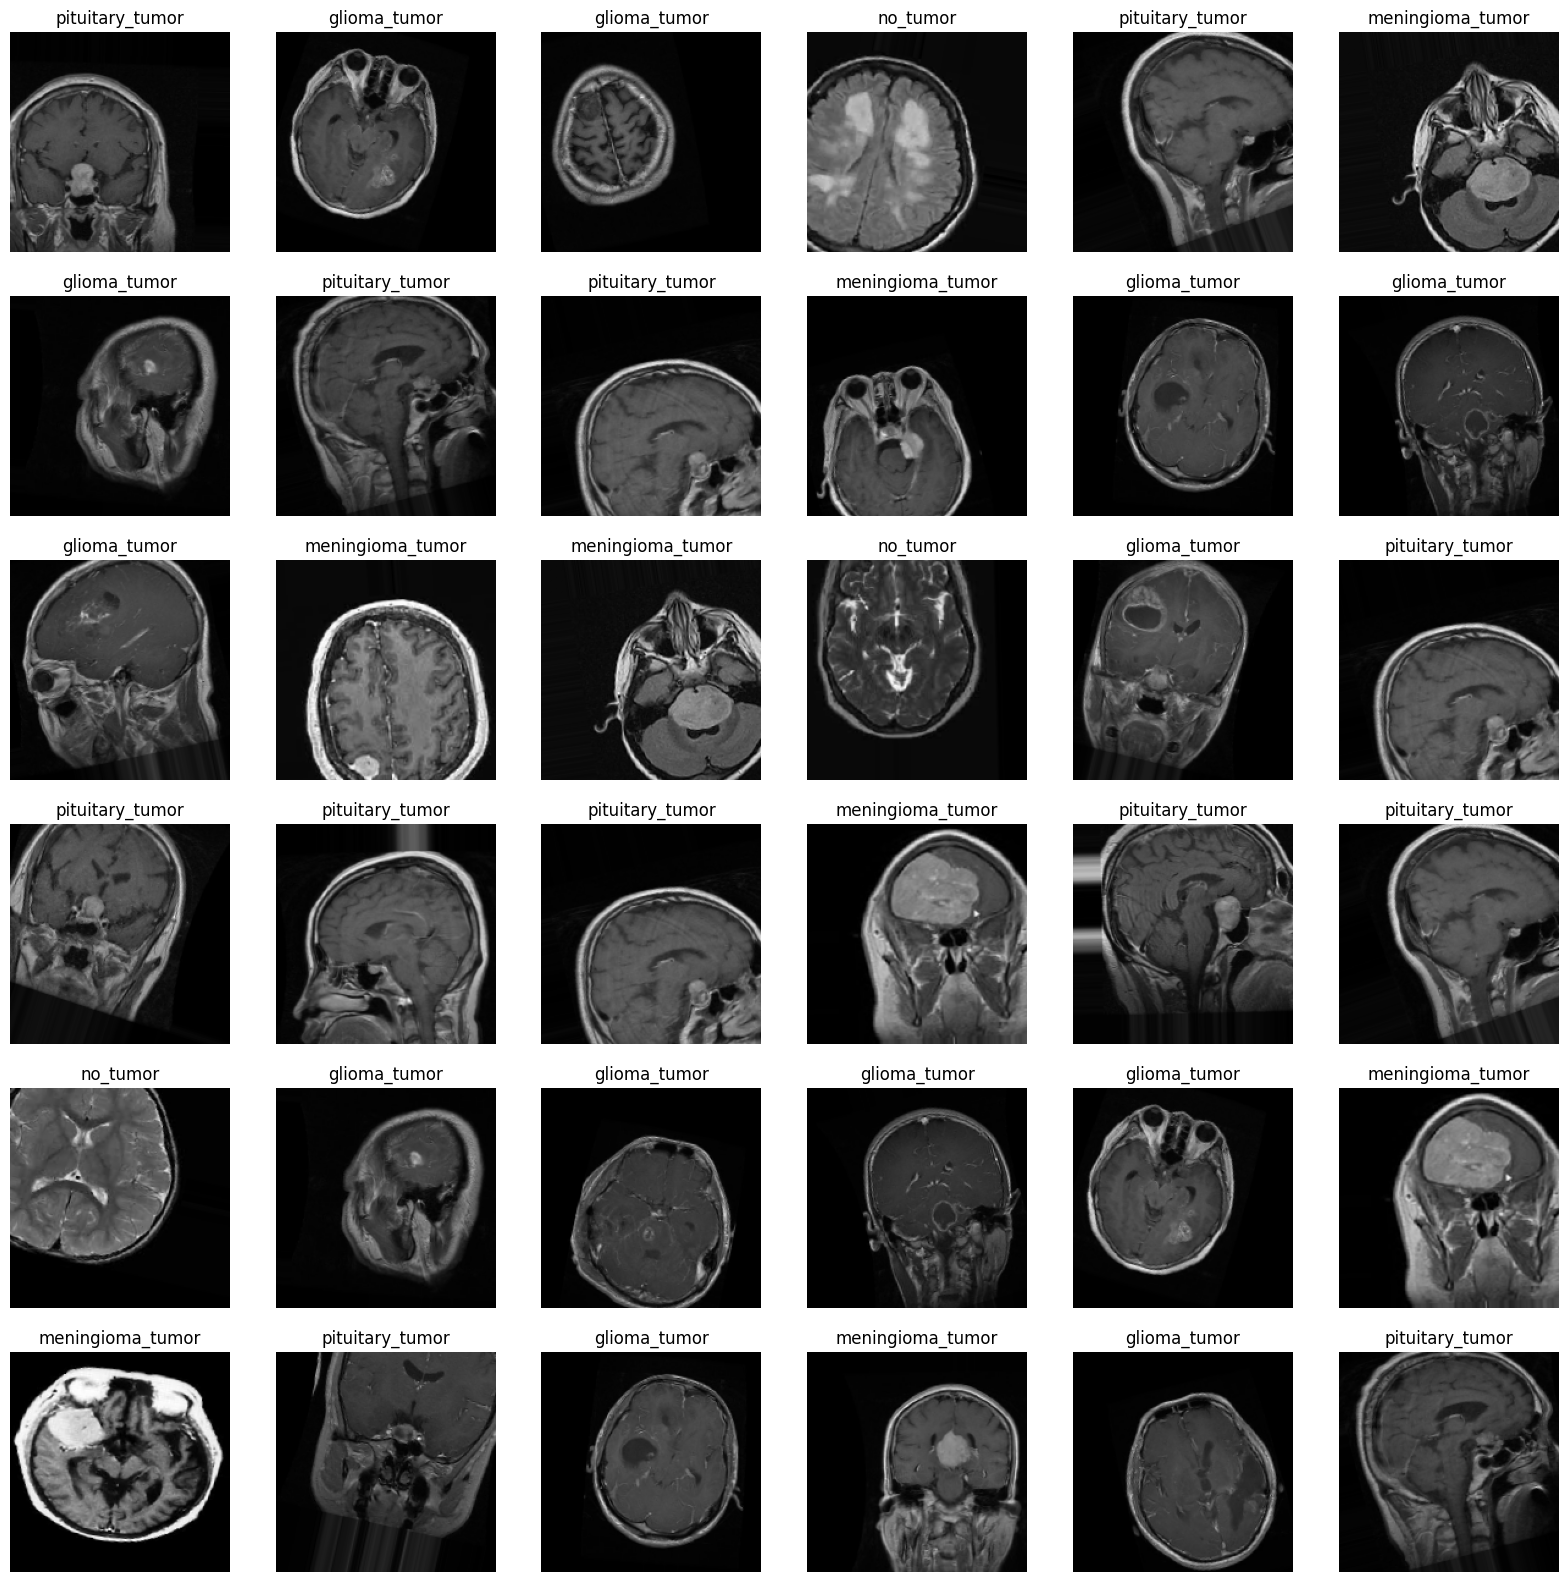

In [45]:
Show_Images(train_generator)

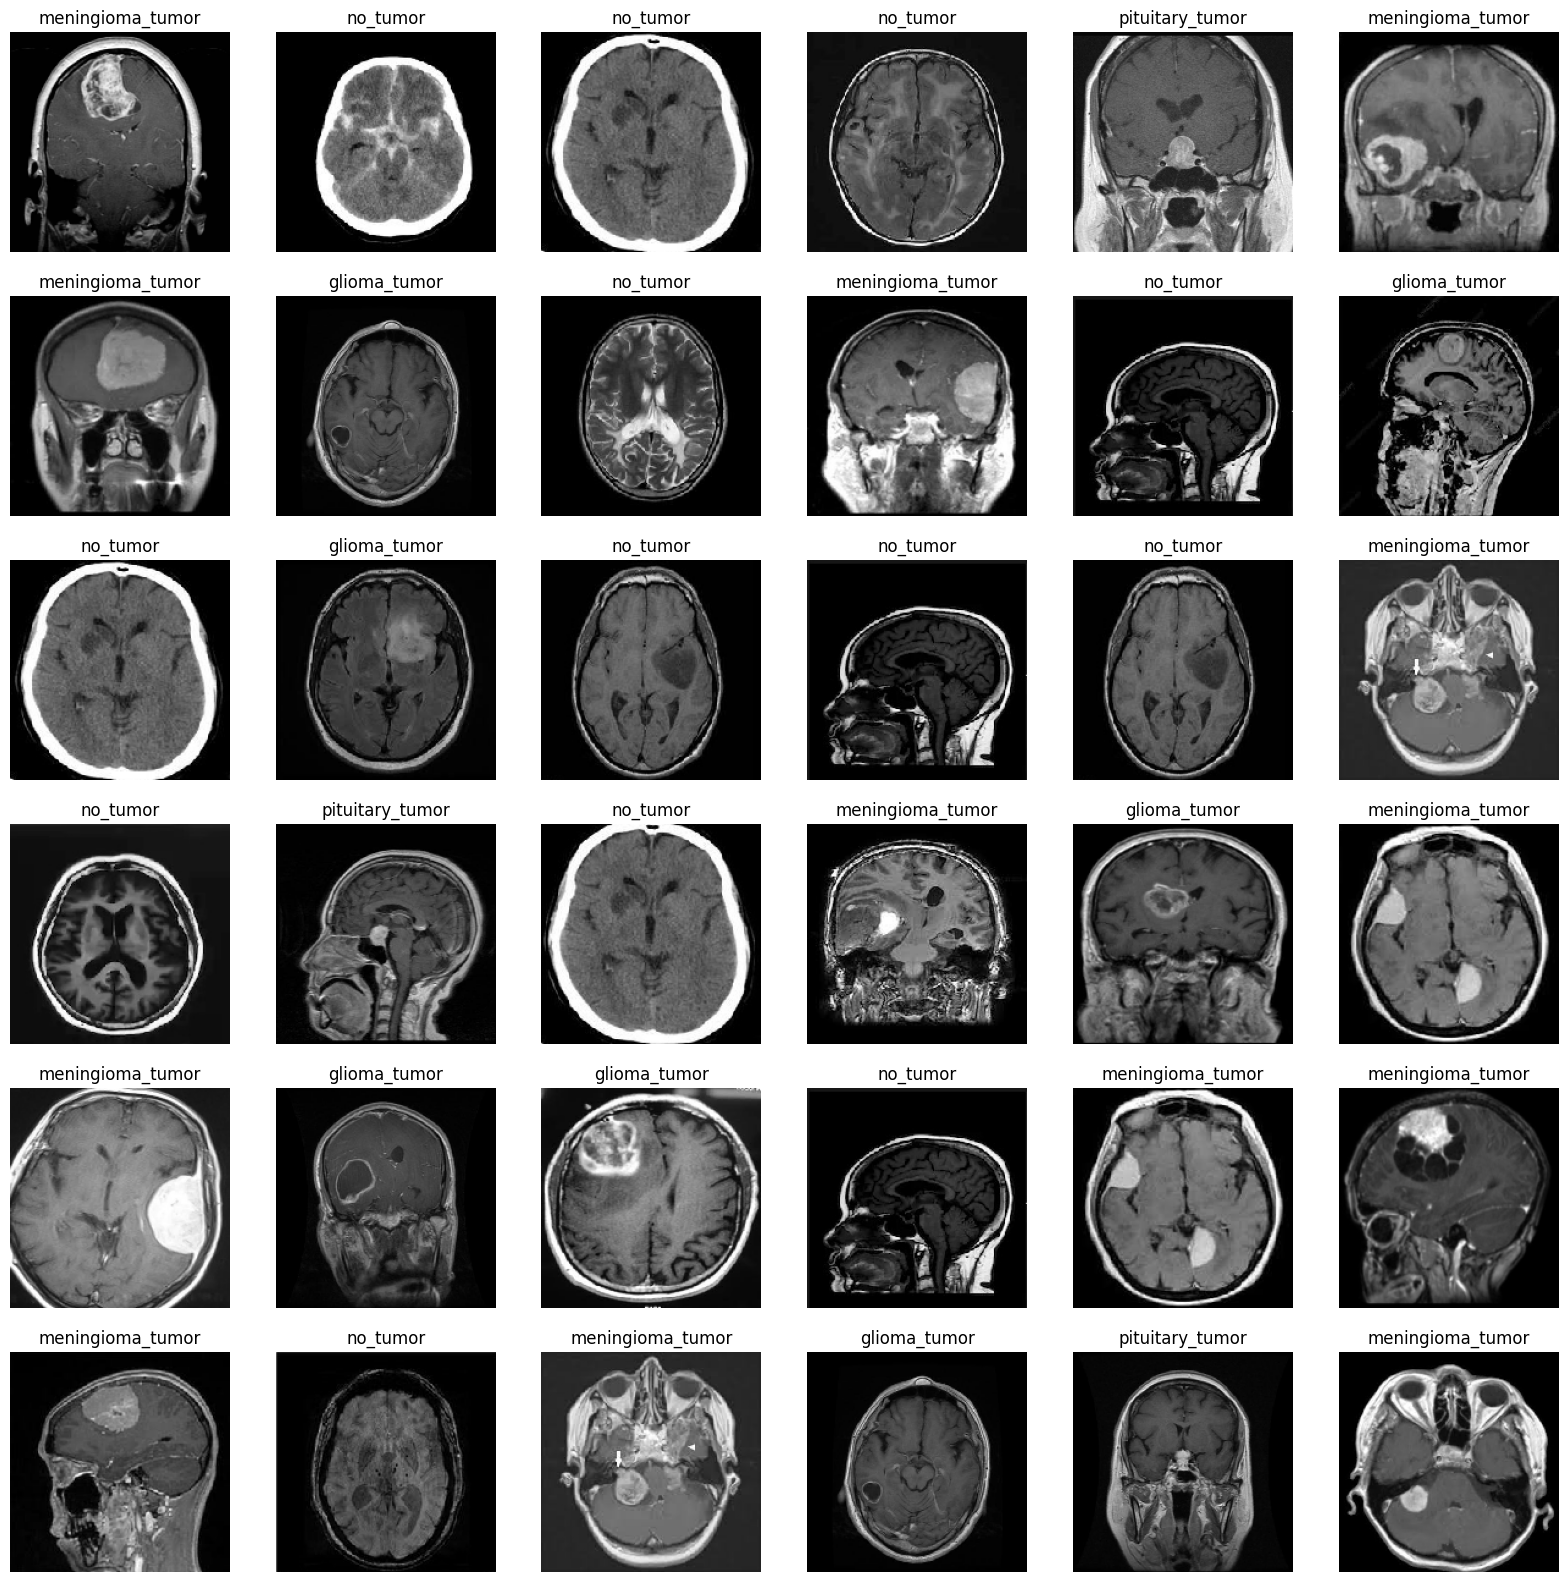

In [46]:
Show_Images(test_generator)

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

In [ ]:
print("x_train shape",X_train.shape)
print("x_test shape",X_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)

x_train shape (2296, 180, 180, 3)
x_test shape (574, 180, 180, 3)
y_train shape (2296,)
y_test shape (574,)


**One Hot Encoding**

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
num_classes = 4  # Sınıf sayısına göre ayarlayın

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# VGG16 modelini yükleyin
base_model = VGG16(weights='imagenet', include_top=False)

# VGG16 modelinin çıkış katmanını alın
x = base_model.output

# Global Average Pooling Layer ekleyin
x = GlobalAveragePooling2D()(x)

# Tam bağlantılı katmanları ekleyin
x = Dense(1024, activation='relu')(x)

# Çıkış katmanını ekleyin (sınıf sayısı kadar nörona sahip olmalı)
output = Dense(num_classes, activation='softmax')(x)

# Yeni modeli oluşturun
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

# VGG16 modelinin dondurulmasını kaldırın (isteğe bağlı)
for layer in base_model.layers:
    layer.trainable = True

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# ModelCheckpoint geri çağırma
checkpoint = ModelCheckpoint("VGG16_model", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# ReduceLROnPlateau geri çağırma
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)

# TensorBoard geri çağırma
tensorboard = TensorBoard(log_dir='logs')

# Modeli derlerken geri çağırma işlevlerini ekleyin
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitirken geri çağırma işlevlerini ekleyin
history1 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=32, callbacks=[checkpoint, reduce_lr, tensorboard])

Epoch 1/25
72/72 [==============================] - ETA: 0s - loss: 1.2099 - accuracy: 0.5383
Epoch 1: val_accuracy improved from -inf to 0.55923, saving model to VGG16_model
72/72 [==============================] - 37s 385ms/step - loss: 1.2099 - accuracy: 0.5383 - val_loss: 1.0011 - val_accuracy: 0.5592 - lr: 0.0010
Epoch 2/25
72/72 [==============================] - ETA: 0s - loss: 0.9116 - accuracy: 0.6119
Epoch 2: val_accuracy improved from 0.55923 to 0.69512, saving model to VGG16_model
72/72 [==============================] - 27s 369ms/step - loss: 0.9116 - accuracy: 0.6119 - val_loss: 0.6839 - val_accuracy: 0.6951 - lr: 0.0010
Epoch 3/25
72/72 [==============================] - ETA: 0s - loss: 0.9389 - accuracy: 0.6333
Epoch 3: val_accuracy did not improve from 0.69512
72/72 [==============================] - 23s 320ms/step - loss: 0.9389 - accuracy: 0.6333 - val_loss: 0.7859 - val_accuracy: 0.6690 - lr: 0.0010
Epoch 4/25
72/72 [==============================] - ETA: 0s - loss:

In [ ]:
import matplotlib.pyplot as plt

# Eğitim işlemi sırasında kaydedilen metrikleri alın
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']
train_accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']

# Loss grafiği
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy grafiği
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Gözlem**

   Data setine önce augmentasyon uyguladım bunu görselleri en başta gösterirken yaptım  sonra aşağıda uyguladım ve daha yüksek doğruluklara ulaştım burada augmentasyonun önemini görüyoruz

In [ ]:
# Modeli derleme
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Veri augmentasyonu için yapılandırmaları belirleyin
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Veri augmentasyonunu uygulayın
augmented_data = []
for img in X_train:
    augmented_img = datagen.random_transform(img)
    augmented_data.append(augmented_img)

# Augmented verileri eğitim verilerine ekleyin
X_train = np.concatenate((X_train, augmented_data), axis=0)
y_train = np.concatenate((y_train, y_train), axis=0)

# Modeli eğitirken veri augmentasyonunu kullanın
history2 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[checkpoint, reduce_lr, tensorboard])

In [ ]:
import matplotlib.pyplot as plt

# Eğitim işlemi sırasında kaydedilen metrikleri alın
train_loss_augmented = history2.history['loss']
val_loss_augmented = history2.history['val_loss']
train_accuracy_augmented = history2.history['accuracy']
val_accuracy_augmented = history2.history['val_accuracy']

# Loss grafiği
plt.figure(figsize=(12, 6))
plt.plot(train_loss_augmented, label='Training Loss (Augmented)', color='blue')
plt.plot(val_loss_augmented, label='Validation Loss (Augmented)', color='red')
plt.title('Training and Validation Loss (Augmented)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy grafiği
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy_augmented, label='Training Accuracy (Augmented)', color='blue')
plt.plot(val_accuracy_augmented, label='Validation Accuracy (Augmented)', color='red')
plt.title('Training and Validation Accuracy (Augmented)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

# Test verileri üzerinde tahmin yapın
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerçek sınıfları alın
y_true = np.argmax(y_test, axis=1)

# Confusion matrix'i oluşturun
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Heatmap'i çizin
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
sns.heatmap(conf_matrix, ax=ax, xticklabels=labels, yticklabels=labels, annot=True,
            cmap=colors_green[::-1], alpha=0.7, linewidths=2, linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix', size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1], y=0.92, x=0.28, alpha=0.8)

plt.show()

# ***Sonuç***
    Bu projede sağlık veriliri ile yapılan bir araştırmada MobileNetV3 modelinin kullanılmasının daha iyi sonuç vereceğini öğrenmiş oldum
    
    Ben VGG16 modelini kullandığımda daha düşük bir doğruluk değerine ulaşmış oldum